<a href="https://colab.research.google.com/github/LeeMonet/Misc_Work/blob/main/QuantumEnhancedMCMC_Neal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
# Phys 507: Introduction to Quantum Computing  
# Spring 2025  
# Janie Neal


## Based on [Quantum Enhanced Markov Chain Monte Carlo](https://arxiv.org/abs/2203.12497)

# Imports and Installations

In [1]:
!pip install qiskit pylatexenc qiskit_aer

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
import random

# Helper Functions

In [3]:
def initialize_state(circuit, s):
    for i, bit in enumerate(s):
        if bit == 1:
            circuit.x(i)

def bitstring_to_spin(bitstring):
    return [1 if b == '0' else -1 for b in bitstring]

def spin_to_bitstring(spin):
    return [0 if s == 1 else 1 for s in spin]



## Unitary Operator: Hamiltonian Evolution


\begin{align}
U = e^{-iHt}  \text{ where } H = (1-\gamma)\alpha H_{\text{prob}} + \gamma H_{\text{mix}}\\
H_{\text{prob}} = -\sum_{(j,k)} J_{jk} Z_j Z_k - \sum_j h_j Z_j \text{ and }
H_{\text{mix}} = \sum_j X_j
\end{align}


### Lie-Trotter



**The Lie-Trotter product formula.**

$$e^{-i \left( (1-\gamma)\alpha H_{\text{prob}} + \gamma H_{\text{mix}} \right) t}
\approx
e^{-i \gamma H_{\text{mix}} t}
e^{-i (1-\gamma)\alpha H_{\text{prob}} t}
+ O(t^2)$$

The paper uses a second order trotterization but this one was simpler to implement first.


In [62]:
def apply_lie_trotter_evolution(qc, J, h, gamma, t, alpha, r= None):

    #hprob - its ok to split like this because z's commute
    for (j, k), Jval in J.items():
        theta = -2 * (1 - gamma) * alpha * Jval * t
        qc.rzz(theta, j, k)
    for j, hval in h.items():
        theta = -2 * (1 - gamma) * alpha * hval * t
        qc.rz(theta, j)

    #hmix
    for j in range(n):
        theta = -2 * gamma * t
        qc.rx(theta, j)


### Second order Trotter Suzuki with multistep

$$U(t) = \left( e^{-i H_{\text{mix}} \frac{t}{2r}} \, e^{-i H_{\text{prob}} \frac{t}{r}} \, e^{-i H_{\text{mix}} \frac{t}{2r}} \right)^r + \mathcal{O}\left( \frac{t^3}{r^2} \right)$$


In [5]:
def apply_trotter_suzuki_evolution(qc, J, h, gamma, t, alpha, r=1):
    for _ in range(r):
        # Half step for Hmix
        for j in range(n):
            theta = -gamma * t / (2 * r)
            qc.rx(2 * theta, j)

        # Full step for Hprob
        for (j, k), Jval in J.items():
            theta = -(1 - gamma) * alpha * Jval * t / r
            qc.rzz(2 * theta, j, k)
        for j, hval in h.items():
            theta = -(1 - gamma) * alpha * hval * t / r
            qc.rz(2 * theta, j)

        # Half step for Hmix again
        for j in range(n):
            theta = -gamma * t / (2 * r)
            qc.rx(2 * theta, j)


## Ising Energy

$$
E(s) = -\sum_{(j,k)} J_{jk} \, s_j s_k - \sum_j h_j \, s_j
$$

In [6]:
def ising_energy(s, J, h):
    energy = 0
    for (j, k), val in J.items():
        energy -= val * s[j] * s[k]
    for j, val in h.items():
        energy -= val * s[j]
    return energy


## Acceptance Probability

$$A(s' \mid s) = \min\left(1, \exp\left(-\frac{E(s') - E(s)}{T}\right)\right)$$


In [7]:

def classical_acceptance(E_old, E_new, T):
    delta_E = E_new - E_old
    acceptance_prob = min(1, np.exp(-delta_E / T))
    return random.uniform(0, 1) < acceptance_prob



## MCMC

In [106]:
def mcmc(J, h, T, num_steps, apply_hamiltonian_evolution, r=1, first_spin=None, print_steps=False):
  if first_spin: current_spin = first_spin
  else: current_spin  = [random.choice([1, -1]) for _ in range(n)]


  #current_spin  = [random.choice([1, -1]) for _ in range(n)]
  current_energy = ising_energy(current_spin, J, h)
  trajectory = [current_spin.copy()]

  alpha = np.sqrt(n) / np.sqrt(sum(Jval**2 for Jval in J.values()) + sum(hval**2 for hval in h.values())) #scaling term

  for step in range(num_steps):
      gamma = random.uniform(0.25, 0.6) #random every step like paper
      t = random.uniform(2, 20) #random every step like paper

      qc = QuantumCircuit(n, n)
      initialize_state(qc, spin_to_bitstring(current_spin))
      apply_hamiltonian_evolution(qc, J, h, gamma, t, alpha, r=r)
      qc.measure(range(n), range(n))

      # Run the simulation
      qc = transpile(qc, simulator)
      job = simulator.run(qc)
      result = job.result()
      counts = result.get_counts()


      sampled_bitstring = list(counts.keys())[0]
      proposed_spin = bitstring_to_spin(sampled_bitstring)
      proposed_energy = ising_energy(proposed_spin, J, h)

      # Accept/reject
      if classical_acceptance(current_energy, proposed_energy, T):
          current_spin = proposed_spin
          current_energy = proposed_energy

      trajectory.append(current_spin.copy())
      if print_steps: print(f"Step {step}: {current_spin}")

  return trajectory, qc




# Run Simulations

## Parameters

In [141]:
n = 6 # number of spins/qubits
T = 0.1  # temperature
num_steps = 100

# Random Ising model
np.random.seed(42)
J = {(i, i+1): np.random.randn() for i in range(n-1)}  # nearest neighbor couplings
h = {i: np.random.randn() for i in range(n)}  # local fields


first_spin= [random.choice([1, -1]) for _ in range(n)]


## run with lie trotter

In [142]:
simulator = AerSimulator()


traj_lie, qc = mcmc(J, h, T, num_steps, apply_lie_trotter_evolution, first_spin=first_spin)

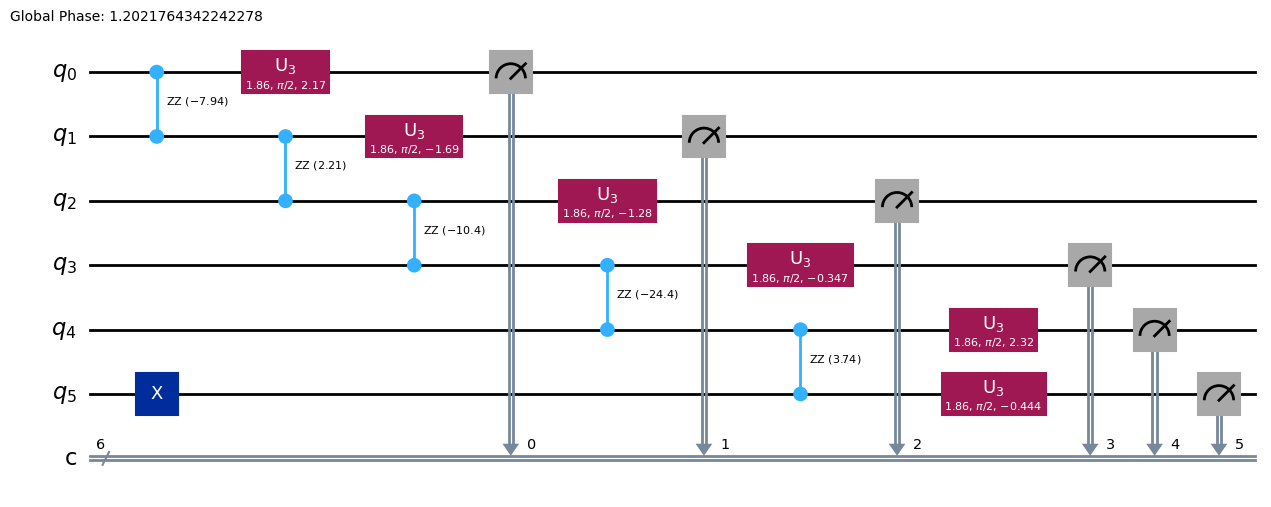

In [143]:
qc.draw('mpl')

## run with second order trotter suzuki, r=1


In [144]:
simulator = AerSimulator()


traj_suz, qc = mcmc(J, h, T, num_steps, apply_trotter_suzuki_evolution, first_spin=first_spin)

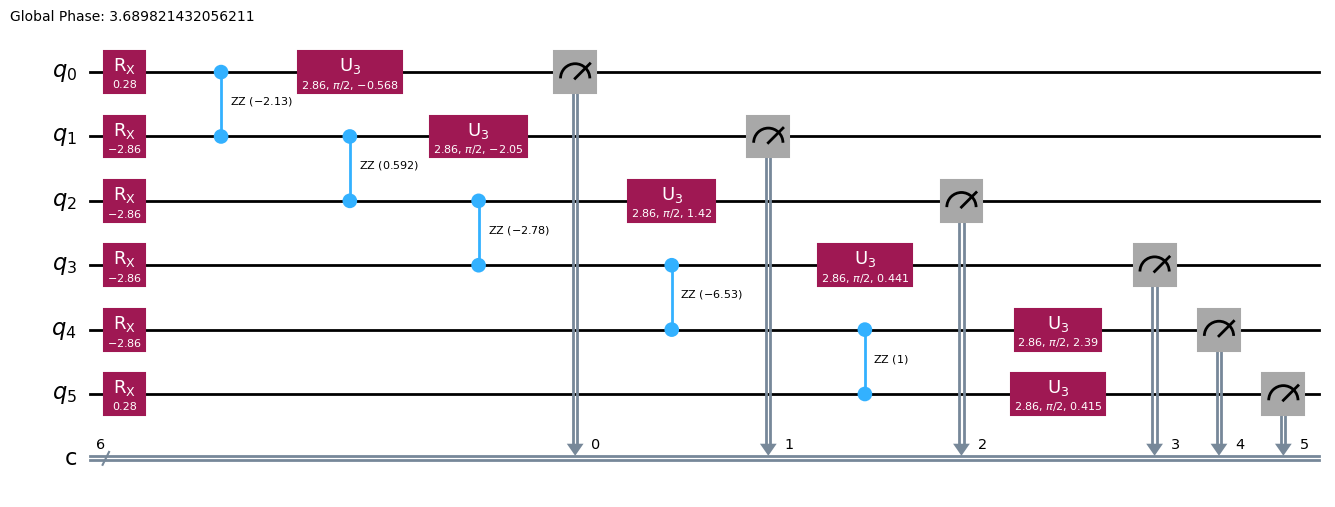

In [145]:
qc.draw('mpl')

## run with second order trotter suzuki, r=3

In [146]:
simulator = AerSimulator()


traj_suz3, qc = mcmc(J, h, T, num_steps, apply_trotter_suzuki_evolution, r=3, first_spin=first_spin)

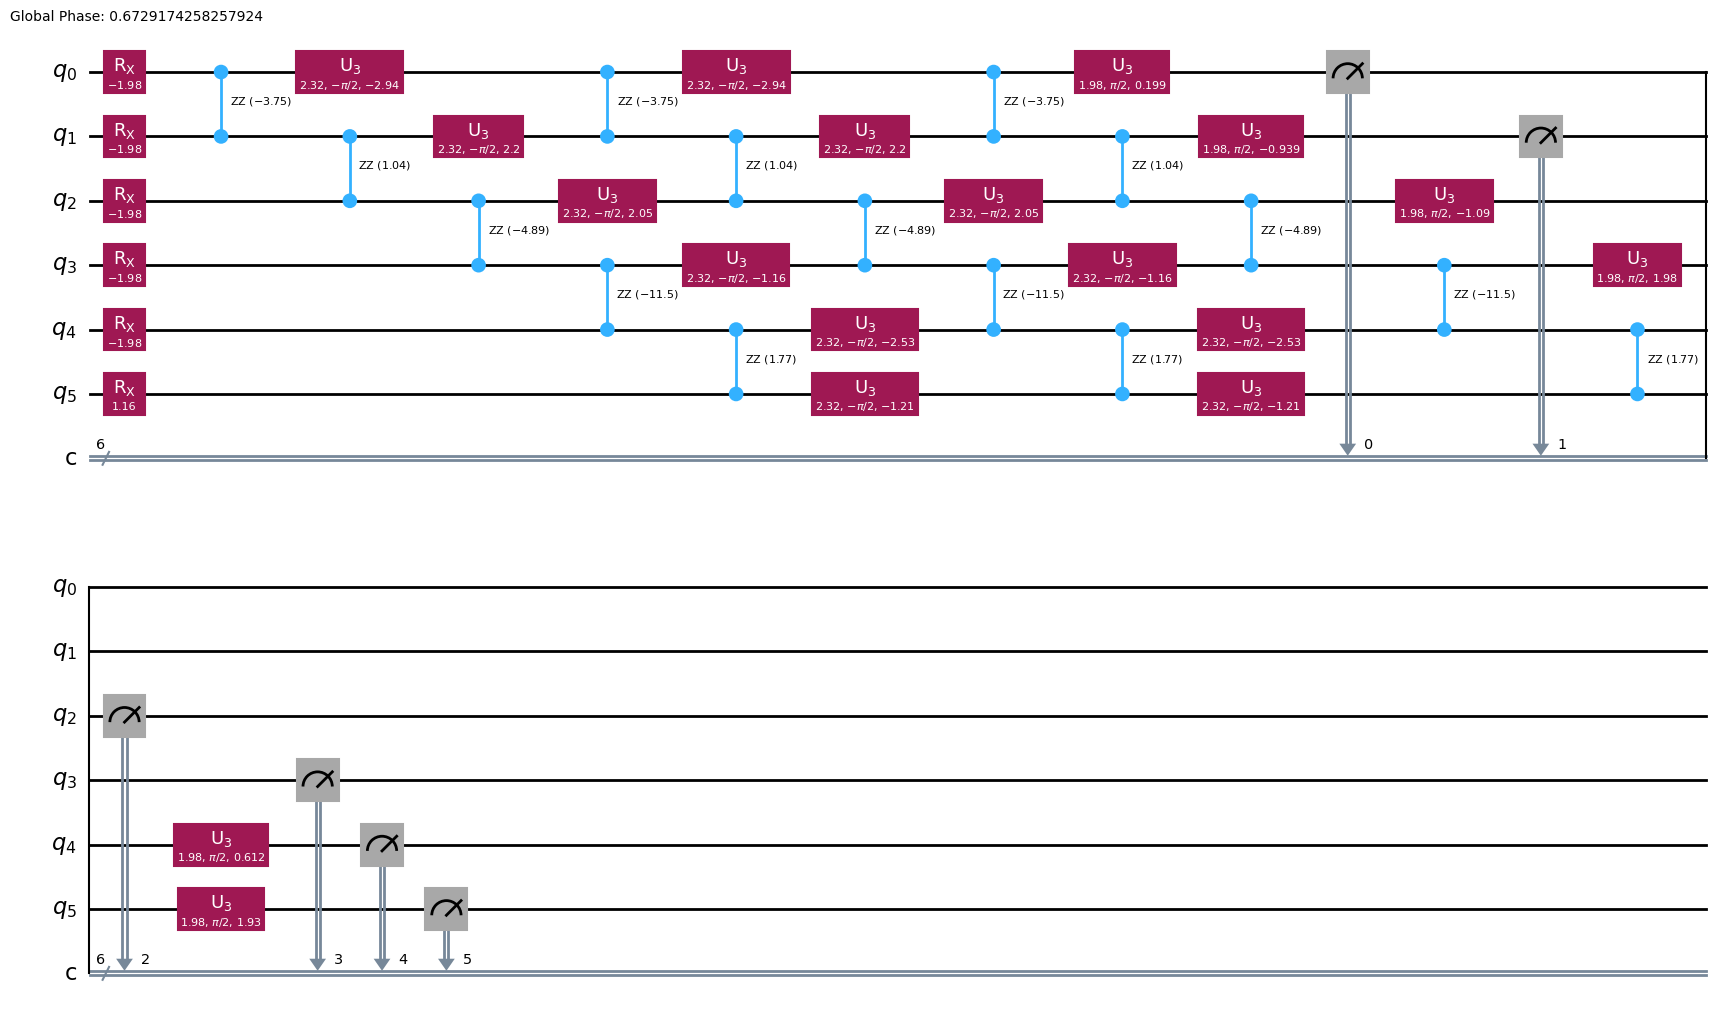

In [147]:
qc.draw('mpl')

## higher r's

In [148]:
traj_suz5, qc = mcmc(J, h, T, num_steps, apply_trotter_suzuki_evolution, r=5, first_spin=first_spin)


traj_suz7, qc = mcmc(J, h, T, num_steps, apply_trotter_suzuki_evolution, r=7, first_spin=first_spin)

# Energy Evolution Comparisons

In [149]:
trajs = [traj_lie, traj_suz, traj_suz3, traj_suz5, traj_suz7]
titles = ["Trotter_Lie", "Trotter_Suzuki, r=1", "Trotter_Suzuki, r=3", "Trotter_Suzuki, r=5", "Trotter_Suzuki, r=7"]

In [150]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_energy_trajectories(list_of_trajectories, J, h, titles=None):
    n_runs = len(list_of_trajectories)
    fig, axes = plt.subplots(n_runs, 1, figsize=(10, 3*n_runs), sharex=True)

    if n_runs == 1:
        axes = [axes]  # Force list for uniform handling

    # First: compute energies for all trajectories
    all_energies = []
    energies_per_run = []
    for traj in list_of_trajectories:
        energies = [ising_energy(state, J, h) for state in traj]
        energies_per_run.append(energies)
        all_energies.extend(energies)

    # Find global min and max for y-axis
    ymin, ymax = min(all_energies), max(all_energies)
    margin = 0.05 * (ymax - ymin)  # Add 5% margin
    ymin -= margin
    ymax += margin

    # Now plot
    for idx, (energies, ax) in enumerate(zip(energies_per_run, axes)):
        ax.plot(energies, marker='o', linestyle='-', alpha=0.8)
        ax.set_ylabel('Energy')
        ax.set_ylim(ymin, ymax)  # Force same y-axis range
        ax.grid(True)
        if titles is not None:
            ax.set_title(titles[idx])
        else:
            ax.set_title(f'Trajectory {idx+1}')

    axes[-1].set_xlabel('MCMC Step')
    fig.suptitle('Energy Trajectories Over MCMC Runs', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


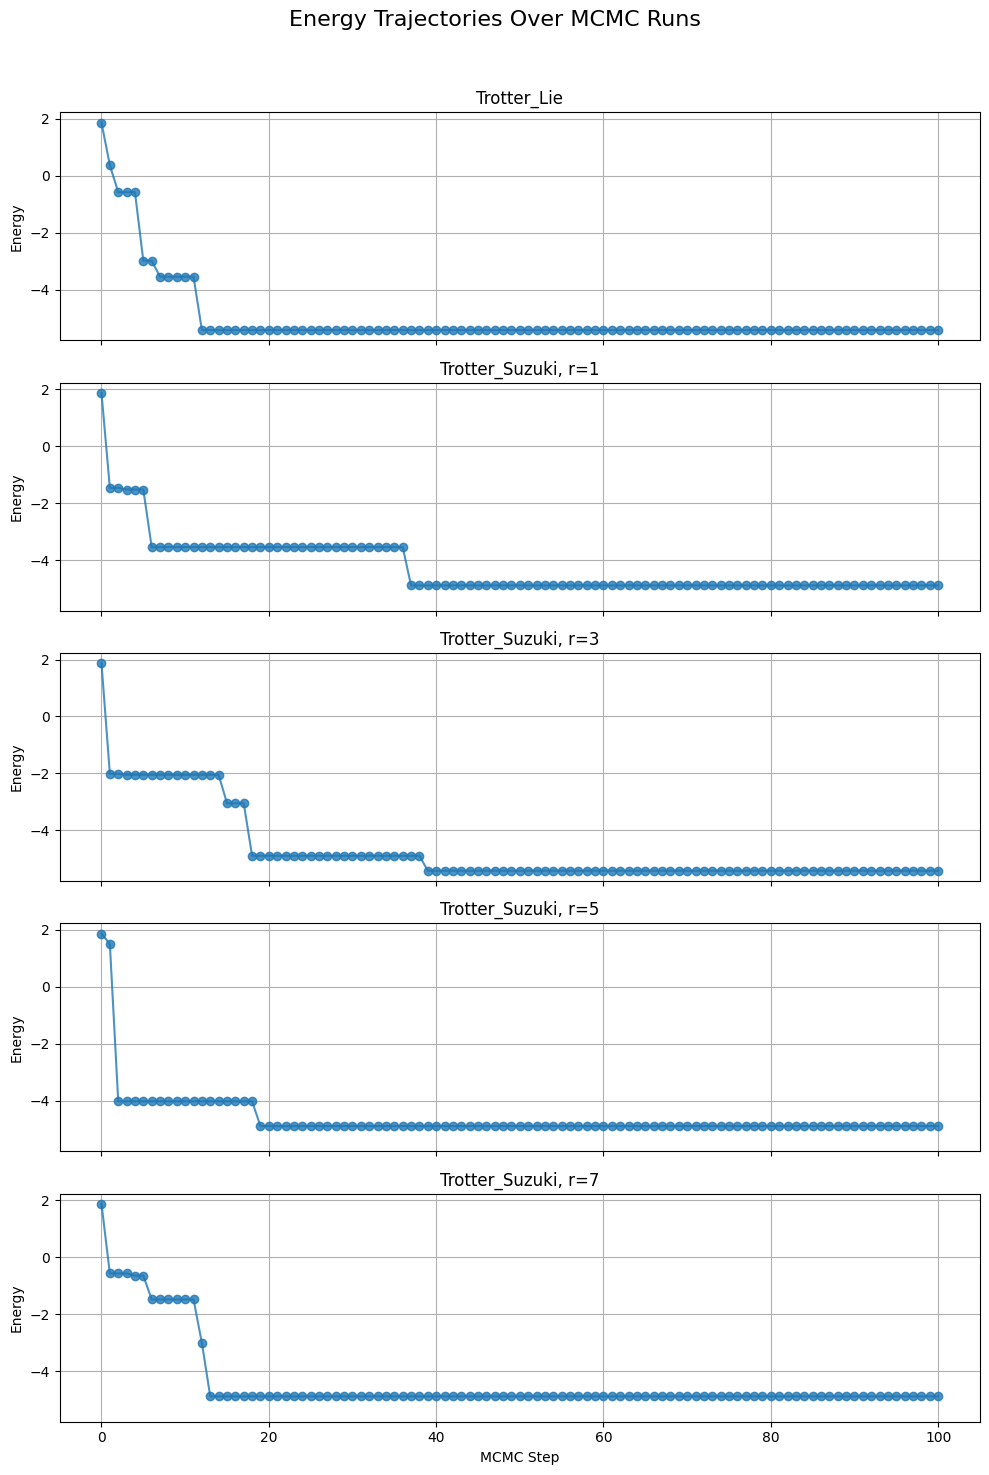

In [151]:
plot_energy_trajectories(
    trajs,
    J, h,
    titles=titles
)


# Resources


[Aer Tutorial](https://github.com/Qiskit/qiskit-aer/blob/main/docs/tutorials/1_aersimulator.ipynb)

[Lie Trotter in Qiskit](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.LieTrotter)


[Trotterization](https://qiskit-community.github.io/qiskit-algorithms/tutorials/13_trotterQRTE.html)
